## CNN Model for Camelyon 16 Challenge

Following the data processing part in the [Camelyon16_data](https://colab.research.google.com/drive/1Dr0XTDCni0DcxJaaBFbIXTgnLH96Nzrl#scrollTo=TANVVXDpDdcX), we are now building the model for tumor image classification in the Camelyon 16 challenge. To start, we also need to install the [OpenSlide](https://openslide.org/), [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) at Colab.



### Model outline

The goal for this project is to build a thoughtful, end-to-end prototype - based on this [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. The model includes the following:
- Use multiple zoom levels (level 5 and 6)
- Use high-magnification images (extract 299*299 size patches for training)
- Include several visualizations and evaluations of the results 
    - heatmaps: showing predictions on individual slides
    - metrics - Area Under ROC (slide-level classfication) and FROC (tumor detection and localization): evaluating the model performance


In [0]:
# Fixing a bug with setuptools & openslide
# https://github.com/openslide/openslide-python/issues/79
# First, run this command
# !pip uninstall setuptools

In [0]:
# Then, run this command
# !pip install setuptools==45.3.0

# After that finishes:
# 1) Comment out the ```!pip uninstall setuptools``` line above
# 2) Comment out the ``!pip install setuptools==45.3.0``` line above
# 3) Use `Runtime -> restart and run all` on the menu
# And the rest of the notebook should work

In [3]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

### Transfer learning

We use tramsfer learning on the pre-trained models 'VGG16' to train our cancer images. We will fine-tune the last layers and compare their results.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential, layers, optimizers, models
from tensorflow.keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [7]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
BATCH_SIZE = 32
PATCH_SIZE = 299

SLIDE_IMAGE_PATH = '/content/drive/My Drive/slides/'
PATCH_IMAGE_PATH = '/content/drive/My Drive/patches/'

LEVEL5_TRAIN_DIR = PATCH_IMAGE_PATH + "level_5/train/"
LEVEL5_VAL_DIR = PATCH_IMAGE_PATH + "level_5/val/"
LEVEL5_TEST_DIR = PATCH_IMAGE_PATH + "level_5/test/"
LEVEL6_TRAIN_DIR = PATCH_IMAGE_PATH + "level_6/train/"
LEVEL6_VAL_DIR = PATCH_IMAGE_PATH + "level_6/val/"
LEVEL6_TEST_DIR = PATCH_IMAGE_PATH + "level_6/test/"

#### Build Model (VGG16)

In [9]:
# pre-trained model VGG16
vgg_conv = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(PATCH_SIZE, PATCH_SIZE, 3)) #include_top=False discard the top dense layers
vgg_conv.trainable = False

# model 1: level 5 vgg model
# define new model and add new classifier layer
vgg_model_5 = Sequential()
vgg_model_5.add(layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3)))
vgg_model_5.add(vgg_conv)

vgg_model_5.add(layers.GlobalAveragePooling2D())
vgg_model_5.add(layers.Dense(256, activation='relu'))
vgg_model_5.add(layers.Dense(2)) 

# summarize
# vgg_model_5.summary()


# model 2: level 6 vgg model
# define new model and add new classifier layer
vgg_model_6 = Sequential()
vgg_model_6.add(layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3)))
vgg_model_6.add(vgg_conv)

vgg_model_6.add(layers.GlobalAveragePooling2D())
vgg_model_6.add(layers.Dense(256, activation='relu'))
vgg_model_6.add(layers.Dense(2)) 

# summa6rize
vgg_model_6.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


#### Create data generator
We define a function to create data generators for the given level and data directory. Depending on if the dataset is training set, we will choose to do data augmentation or not.

In [0]:
## create data generator
def create_data_generator(level=5, data_dir=LEVEL5_TRAIN_DIR, is_train=True):

    if is_train: #only augment data on the training set
        datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    brightness_range=[0.9,1.2],
                                    zoom_range=[0.6,1.1],
                                    horizontal_flip=True, 
                                    vertical_flip=True
                                    )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_train)  #only shuffle for train dataset
    return generator


In [11]:
## Train dataset
train_generator_5 = create_data_generator(level=5, data_dir=LEVEL5_TRAIN_DIR)
train_generator_6 = create_data_generator(level=6, data_dir=LEVEL6_TRAIN_DIR)

## Validation dataset
val_generator_5 = create_data_generator(level=5, data_dir=LEVEL5_VAL_DIR, is_train=False)
val_generator_6 = create_data_generator(level=6, data_dir=LEVEL6_VAL_DIR, is_train=False)

## Test dataset
test_generator_5 = create_data_generator(level=5, data_dir=LEVEL5_TEST_DIR, is_train=False)
test_generator_6 = create_data_generator(level=6, data_dir=LEVEL6_TEST_DIR, is_train=False)

Found 1469 images belonging to 2 classes.
Found 1395 images belonging to 2 classes.
Found 410 images belonging to 2 classes.
Found 358 images belonging to 2 classes.
Found 397 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


#### Training model

In [12]:
vgg_model_5.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

##fit_generator is deprecated, now we can directly use fit for data generator
vgg_history_5 = vgg_model_5.fit(train_generator_5, 
                                steps_per_epoch = len(train_generator_5), 
                                validation_data = val_generator_5, 
                                validation_steps = len(val_generator_5), 
                                epochs=15)


Epoch 1/15
46/46 [==============================] - 41s 901ms/step - loss: 0.7693 - acc: 0.6270 - val_loss: 1.0711 - val_acc: 0.5634
Epoch 2/15
46/46 [==============================] - 41s 893ms/step - loss: 0.6328 - acc: 0.6896 - val_loss: 0.6832 - val_acc: 0.6805
Epoch 3/15
46/46 [==============================] - 41s 893ms/step - loss: 0.6045 - acc: 0.7209 - val_loss: 0.5758 - val_acc: 0.7000
Epoch 4/15
46/46 [==============================] - 40s 879ms/step - loss: 0.5747 - acc: 0.7311 - val_loss: 0.6160 - val_acc: 0.6878
Epoch 5/15
46/46 [==============================] - 41s 885ms/step - loss: 0.6733 - acc: 0.7195 - val_loss: 0.5603 - val_acc: 0.7195
Epoch 6/15
46/46 [==============================] - 40s 878ms/step - loss: 0.6955 - acc: 0.7352 - val_loss: 0.5407 - val_acc: 0.7000
Epoch 7/15
46/46 [==============================] - 40s 877ms/step - loss: 0.5563 - acc: 0.7434 - val_loss: 0.5336 - val_acc: 0.7122
Epoch 8/15
46/46 [==============================] - 40s 875ms/step - 

In [14]:
vgg_model_6.compile(optimizer=optimizers.RMSprop(lr=2e-4), 
                    loss='categorical_crossentropy', 
                    metrics=['acc'])

##fit_generator is deprecated, now we can directly use fit for data generator
vgg_history_6 = vgg_model_6.fit(train_generator_6, 
                                steps_per_epoch = len(train_generator_6), 
                                validation_data = val_generator_6, 
                                validation_steps = len(val_generator_6), 
                                epochs=15)


Epoch 1/15
44/44 [==============================] - 528s 12s/step - loss: 0.6238 - acc: 0.3247 - val_loss: 0.5496 - val_acc: 0.3128
Epoch 2/15
44/44 [==============================] - 38s 859ms/step - loss: 0.5222 - acc: 0.2674 - val_loss: 0.5157 - val_acc: 0.2877
Epoch 3/15
44/44 [==============================] - 38s 856ms/step - loss: 0.5192 - acc: 0.2373 - val_loss: 0.4894 - val_acc: 0.2542
Epoch 4/15
44/44 [==============================] - 38s 854ms/step - loss: 0.6747 - acc: 0.2258 - val_loss: 0.4760 - val_acc: 0.2402
Epoch 5/15
44/44 [==============================] - 38s 855ms/step - loss: 0.5788 - acc: 0.2201 - val_loss: 0.6031 - val_acc: 0.2458
Epoch 7/15
44/44 [==============================] - 38s 861ms/step - loss: 0.6757 - acc: 0.2072 - val_loss: 0.7579 - val_acc: 0.2374
Epoch 8/15
44/44 [==============================] - 38s 854ms/step - loss: 0.9858 - acc: 0.2258 - val_loss: 0.5668 - val_acc: 0.2514
Epoch 9/15
44/44 [==============================] - 38s 858ms/step - l

We plot the history of accuracy to evaluate the training result.

vgg model for level 5 training history


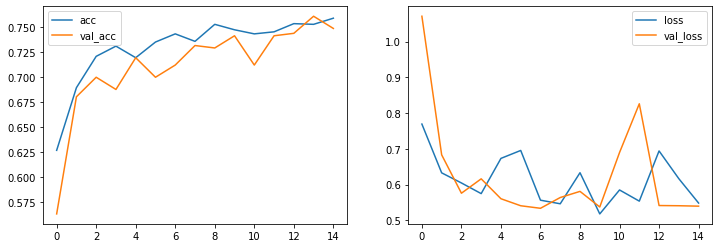

In [37]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
print("VGG16 model for level 5 training history")
axs[0].plot(vgg_history_5.history['acc'], label='acc')
axs[0].plot(vgg_history_5.history['val_acc'], label='val_acc')
axs[0].legend()

axs[1].plot(vgg_history_5.history['loss'], label='loss')
axs[1].plot(vgg_history_5.history['val_loss'], label='val_loss')
axs[1].legend()

The model for level 5 is performing well. The training result and validation result converges at the similar epoch, showing highest accuracy of around 78% and implying no overfitting.

VGG16 model for level 6 training history


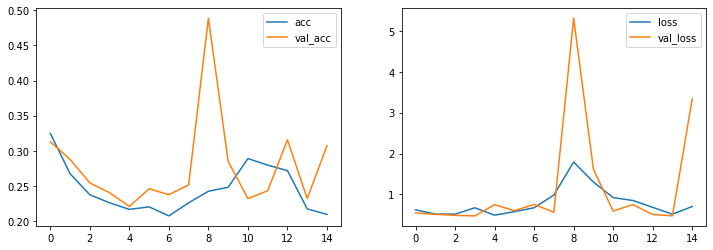

In [38]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
print("VGG16 model for level 6 training history")
axs[0].plot(vgg_history_6.history['acc'], label='acc')
axs[0].plot(vgg_history_6.history['val_acc'], label='val_acc')
axs[0].legend()

axs[1].plot(vgg_history_6.history['loss'], label='loss')
axs[1].plot(vgg_history_6.history['val_loss'], label='val_loss')
axs[1].legend()

We can see that the level 6 model does not perform well, as the accuracy is slightly low and hard to converge. In the training process, it fluctuated and ultimately did not converge. This might be because the level 6 patch dataset have much more noises than level 5 and the dataset is smaller. Thus, the training result on the level 6 data is not good.

We conclude that when zooming with different level does not significantly increase the accuracy. So in the next step, we will only use the model with level 5 magnitude to evaluate on the test set.

### Evaluate on test set

#### Loss & accuracy

In [41]:
test_evaluator_5 = vgg_model_5.evaluate(test_generator_5, steps=len(test_generator_5), return_dict=True)
print(test_evaluator_5)

13/13 [==============================] - 3s 215ms/step - loss: 0.4012 - acc: 0.7909
{'loss': 0.40116992592811584, 'acc': 0.7909319996833801}


In [42]:
test_evaluator_6 = vgg_model_6.evaluate(test_generator_6, steps=len(test_generator_6), return_dict=True)
print(test_evaluator_6)

5/5 [==============================] - 2s 410ms/step - loss: 4.3841 - acc: 0.6061
{'loss': 4.3841094970703125, 'acc': 0.6060606241226196}


Two models on the testing set has relatively high accuracy. The level 5 model reaches around 80% accuracy, higher than the level 6 model, showing the same trend as the training dataset.

#### ROC curve

In [108]:
len(test_generator_5)

13

In [114]:
from sklearn.metrics import roc_curve,roc_auc_score
NUM_BATCHES= 30
# save the history over all test batches
tpr_, fpr_ = [], []
score_ = []
i = 0
while(len(score_) < NUM_BATCHES):
    test_image_5, test_label_5 = next(test_generator_5)
    test_pred_5 = vgg_model_5.predict(test_image_5)
    test_pred_label_5 = np.argmax(test_pred_5, axis=-1)
    #test_label_5 = np.argmax(test_label_5, axis=-1) #change one-hot-encoding vector to classes
    try:
        score = roc_auc_score(test_label_5, test_pred_5)    
        score_.append(score)
        fpr, tpr, thresholds = roc_curve(np.argmax(test_pred_5,axis=-1), test_label_5[:,-1])
        fpr_.append(fpr)
        tpr_.append(tpr)
        print(f"test set epoch {i}")
        i += 1
    except:
        pass    

test set epoch 0
test set epoch 1
test set epoch 2
test set epoch 3
test set epoch 4
test set epoch 5
test set epoch 6
test set epoch 7
test set epoch 8
test set epoch 9
test set epoch 10
test set epoch 11
test set epoch 12
test set epoch 13
test set epoch 14
test set epoch 15
test set epoch 16
test set epoch 17
test set epoch 18
test set epoch 19
test set epoch 20
test set epoch 21
test set epoch 22
test set epoch 23
test set epoch 24
test set epoch 25
test set epoch 26
test set epoch 27
test set epoch 28
test set epoch 29


In [132]:
m,n = len(fpr_), len(fpr_[0])
print(m, n)
fpr_array = np.array(fpr_).mean(axis=0)
tpr_array = np.array(tpr_).mean(axis=0)

30 3


Text(0, 0.5, 'true positive rate')

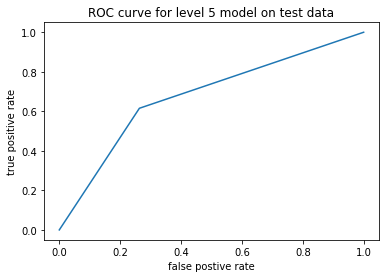

In [135]:
plt.plot(fpr_array, tpr_array)

plt.title("ROC curve for level 5 model on test data")
plt.xlabel("false postive rate")
plt.ylabel("true positive rate")

#### Check on images

In [0]:
test_image_5, test_label_5 = next(test_generator_5)
test_label_5 = np.argmax(test_label_5, axis=-1) #change one-hot-encoding vector to classes

test_pred_5 = vgg_model_5.predict(test_image_5)
test_pred_label_5 = np.argmax(test_pred_5, axis=-1)

Text(0.5, 1.0, 'Level 5 patch: label 0 pred 0 score 0.43')

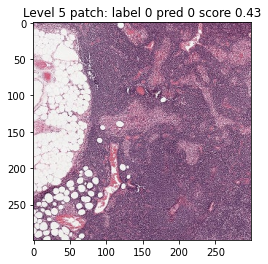

In [162]:
idx = np.random.randint(BATCH_SIZE)
pred_true = test_pred_label_5[idx]==test_label_5[idx]
plt.imshow(test_image_5[idx])
plt.title(f"Level 5 patch: label {test_label_5[idx]} pred {test_pred_label_5[idx]} score {max(test_pred_5[idx])*100//1/100}")

### Visualize on heatmap

We will choose a whole slide image by random and use all its patches to predict the score and draw the heatmap of the slide.

In [0]:
all_slides = np.array(['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059',\
            '075', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110'])

In [0]:
##choose one slide and all its patches
slide_idx = np.random.choice(all_slides)

tumor_patch_paths = []
tumor_path = PATCH_IMAGE_PATH+'level_5/train/tumor/'
for image in os.listdir(tumor_path):
    if image[:3]==slide_idx:
        tumor_patch_paths.append(tumor_path+image)

tumor_patches = []
tumor_patches_pred = []

for img in tumor_patch_paths:
    image = plt.imread(img)
    tumor_patches.append(image)
    new_image = image[np.newaxis,:,:,:3]    
    pred = vgg_model_5.predict(new_image)
    tumor_patches_pred.append(pred)

In [277]:
print(len(tumor_patch_paths))

17


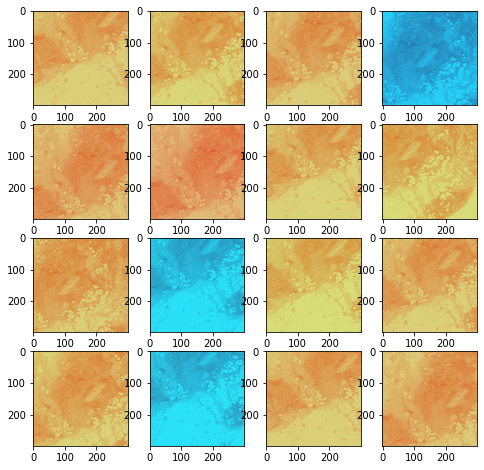

In [281]:
m = 4
n = len(tumor_patches)//m + int(len(tumor_patches[:-1])%m>0)
fig, axs = plt.subplots(m, n, figsize=(m*2,n*2))
for i,img in enumerate(tumor_patches[:-1]):
    image_heat = img
    is_tumor = np.argmax(tumor_patches_pred[i], axis=-1)[0]*2-1  #1 for tumor, -1 for normal
    image_heat[:,:,0] = 0.5*np.max(tumor_patches_pred[i], axis=-1)[0]*is_tumor + 0.5
    image_heat = image_heat[:,:,0]
    axs[i//n][i%n].imshow(img)
    axs[i//n][i%n].imshow(image_heat, cmap='jet', alpha=0.5, vmin=0, vmax=1)


We can see that according to the predictions of image patches, different regions show different colors and contribute to the heatmap. For the tumor slide picking from the tumor patches, most of the regions are hot, meaning that they are tumors, which are consistent with the real labels.